In [8]:
# 1. Load Data and Preprocessing
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [9]:
def load_images_from_folder(folder_path, img_size=(32, 32)):
    images, labels = [], []
    class_names = os.listdir(folder_path)
    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder): continue
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    images.append(img)
                    labels.append(class_name)
            except Exception as e:
                print(f'Error loading {img_path}: {e}')
    return np.array(images), np.array(labels)

In [10]:
dataset_path = '../Sorted-Set'  # Adjust path as needed
X, y = load_images_from_folder(dataset_path)
X_flat = X.reshape(len(X), -1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [11]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [12]:
# 2. Load Trained Models
import joblib
from xgboost import XGBClassifier

rf_model = joblib.load('rf_model.pkl')
svm_model = joblib.load('svm_model.pkl')

# Fix XGBoost model - wrap raw Booster in XGBClassifier
try:
    xgb_model = joblib.load('xgb_model.pkl')
    # Check if it's a raw Booster
    if hasattr(xgb_model, 'get_booster'):
        print('XGBoost model is already XGBClassifier')
    else:
        print('Converting raw Booster to XGBClassifier')
        # Create new XGBClassifier and load the booster
        xgb_clf = XGBClassifier()
        xgb_clf._Booster = xgb_model
        xgb_model = xgb_clf
except Exception as e:
    print(f'Error loading XGBoost model: {e}')
    # Create a new XGBClassifier as fallback
    xgb_model = XGBClassifier()
    xgb_model.fit(X_train, y_train)

lr_model = joblib.load('lr_model.pkl')

XGBoost model is already XGBClassifier


c:\Users\Public\Dev\ML Project\venv\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [13]:
# 3. Voting Ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Verify all models are sklearn-compatible
print(f'RF model type: {type(rf_model)}')
print(f'SVM model type: {type(svm_model)}')
print(f'XGB model type: {type(xgb_model)}')
print(f'LR model type: {type(lr_model)}')

voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('svm', svm_model),
        ('xgb', xgb_model),
        ('lr', lr_model)
    ],
    voting='hard'  # Use hard voting to avoid predict_proba issues
)

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
print('Voting Ensemble Accuracy: {:.4f}'.format(accuracy_score(y_test, y_pred_voting)))
print(classification_report(y_test, y_pred_voting, target_names=encoder.classes_, digits=4))

RF model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
SVM model type: <class 'sklearn.svm._classes.SVC'>
XGB model type: <class 'xgboost.sklearn.XGBClassifier'>
LR model type: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Voting Ensemble Accuracy: 0.8946
              precision    recall  f1-score   support

      benign     0.8616    0.9402    0.8992      1020
   malignant     0.9342    0.8490    0.8896      1020

    accuracy                         0.8946      2040
   macro avg     0.8979    0.8946    0.8944      2040
weighted avg     0.8979    0.8946    0.8944      2040



In [14]:
#joblib.dump(voting_clf, 'voting_ensemble.pkl')
print("✅ Model saved as voting_ensemble.pkl")

✅ Model saved as voting_ensemble.pkl


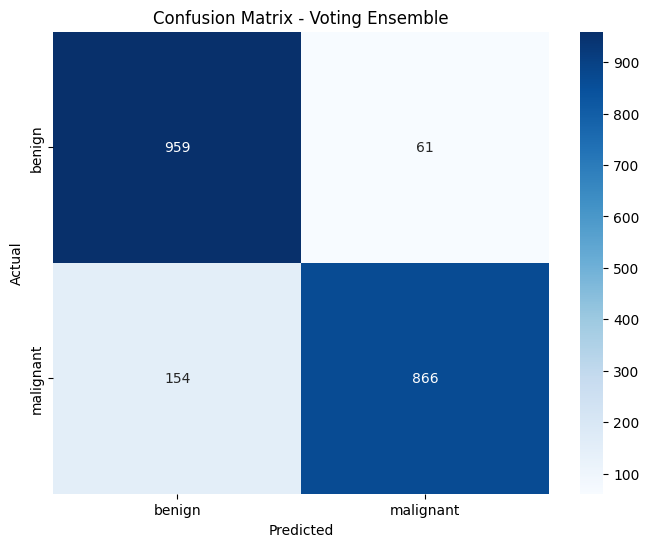

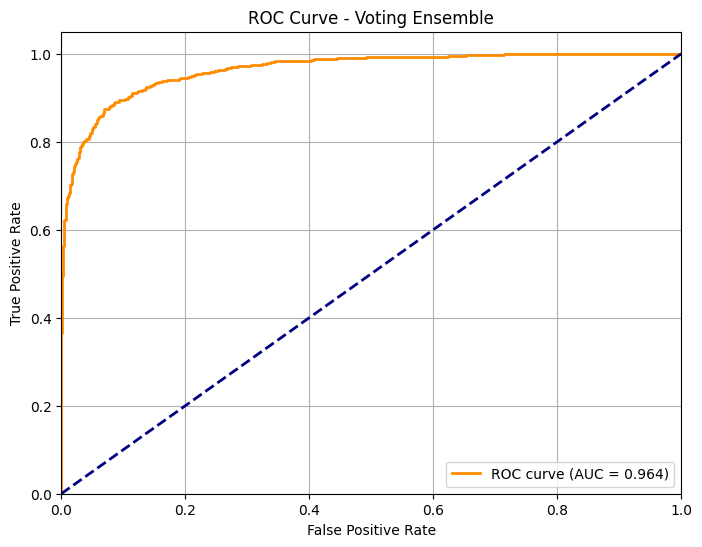

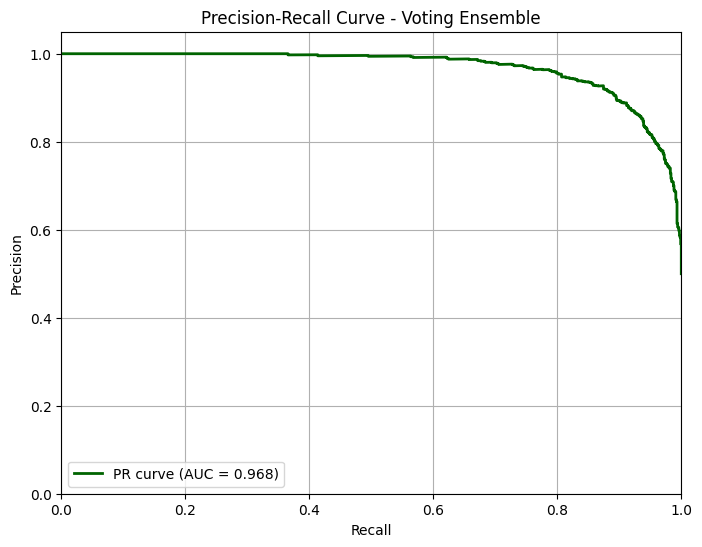

In [15]:
# Voting Ensemble Visualizations
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Create soft voting classifier for probability predictions
voting_clf_soft = VotingClassifier(
    estimators=[('rf', rf_model), ('svm', svm_model), ('xgb', xgb_model), ('lr', lr_model)],
    voting='soft'
)
voting_clf_soft.fit(X_train, y_train)
y_proba_voting = voting_clf_soft.predict_proba(X_test)[:, 1]

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix - Voting Ensemble')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_voting)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Voting Ensemble')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_voting)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkgreen', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Voting Ensemble')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [16]:
# 4. Stacking Ensemble
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_model),
        ('svm', svm_model),
        ('xgb', xgb_model),
        ('lr', lr_model)
    ],
    final_estimator=LogisticRegression(),
    passthrough=True
)
stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)
print('Stacking Ensemble Accuracy: {:.4f}'.format(accuracy_score(y_test, y_pred_stacking)))
print(classification_report(y_test, y_pred_stacking, target_names=encoder.classes_))
#joblib.dump(stacking_clf, 'stacking_ensemble.pkl')

KeyboardInterrupt: 